In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import struct
import requests
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fft
from scipy.signal import get_window, spectrogram
import pickle
import re
from scipy.stats import skew

In [2]:
def get_file_timestamp(filename):
    # ファイル名からタイムスタンプを抽出
    match = re.search(r'_(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})\.npz$', filename)
    return match.group(1) if match else None

def generate_possible_timestamps(timestamp_str):
    # 文字列のタイムスタンプをdatetimeオブジェクトに変換
    timestamp = datetime.strptime(timestamp_str, "%Y-%m-%d_%H-%M-%S")
    # -1秒, 0秒, +1秒の3つのタイムスタンプを生成
    return [
        (timestamp + timedelta(seconds=offset)).strftime("%Y-%m-%d_%H-%M-%S")
        for offset in [-1, 0, 1]
    ]

def find_matching_files(dir1, dir2):
    # ディレクトリ1とディレクトリ2のファイル一覧を取得
    files_dir1 = os.listdir(dir1)
    files_dir2 = os.listdir(dir2)
    
    # ディレクトリ2のファイル名をセットに変換して検索を効率化
    files_dir2_set = set(files_dir2)
    matching_files = []

    for file1 in files_dir1:
        timestamp_str = get_file_timestamp(file1)
        
        if timestamp_str:
            # ±1秒のタイムスタンプ候補を生成
            possible_timestamps = generate_possible_timestamps(timestamp_str)
            
            # ディレクトリ2に一致するタイムスタンプのファイルがあるか確認
            for ts in possible_timestamps:
                matching_file = next((f2 for f2 in files_dir2_set if ts in f2), None)
                if matching_file:
                    matching_files.append((file1, matching_file))
                    break  # 最初に一致したファイルのみ記録
    
    return matching_files

# 使用例
dir1 = '/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'
dir2 = '/mnt/SBOR/2024c_RFSoC/ZCU208/Abort/'
matches = find_matching_files(dir1, dir2)

fuji_file=[]
D5_file=[]
# 結果の表示
for file1, file2 in matches:
    fuji_file.append(file1)
    D5_file.append(file2)
    print(f"Match found: {file1} in dir1, {file2} in dir2")

Match found: LERFUJI_2024-10-27_02-02-02.npz in dir1, LERD5_2024-10-27_02-02-02.npz in dir2
Match found: LERFUJI_2024-10-20_13-51-29.npz in dir1, LERD5_2024-10-20_13-51-29.npz in dir2
Match found: LERFUJI_2024-11-02_16-48-53.npz in dir1, LERD5_2024-11-02_16-48-53.npz in dir2
Match found: LERFUJI_2024-10-21_08-08-53.npz in dir1, LERD5_2024-10-21_08-08-53.npz in dir2
Match found: LERFUJI_2024-10-29_23-49-03.npz in dir1, LERD5_2024-10-29_23-49-03.npz in dir2
Match found: LERFUJI_2024-10-28_02-30-07.npz in dir1, LERD5_2024-10-28_02-30-07.npz in dir2
Match found: LERFUJI_2024-11-01_04-31-16.npz in dir1, LERD5_2024-11-01_04-31-16.npz in dir2
Match found: LERFUJI_2024-10-27_06-17-55.npz in dir1, LERD5_2024-10-27_06-17-55.npz in dir2
Match found: LERFUJI_2024-10-27_23-44-12.npz in dir1, LERD5_2024-10-27_23-44-12.npz in dir2
Match found: LERFUJI_2024-11-04_04-14-19.npz in dir1, LERD5_2024-11-04_04-14-19.npz in dir2
Match found: LERFUJI_2024-11-08_08-50-27.npz in dir1, LERD5_2024-11-08_08-50-27.

In [19]:
def make_spectrum(filename1,filename2,mark=0):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/Abort/'+filename1,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']


    if filename1=="LERFUJI_2024-10-16_08-57-48.npz":
        return
    if filename1=="LERFUJI_2024-10-15_19-08-53.npz":
        return
    if filename1=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    



    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result_x'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum']*(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_x'] = df['result_x'] - df['result_x'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_x'] = np.where(abs(df['result_diff_x']) > 0.7, 0, df['result_diff_x'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=1)

    df['result_y'] = np.where(df['X_sum'] > threshold, df['Y_delta'] / df['Y_sum']*(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_y'] = df['result_y'] - df['result_y'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_y'] = np.where(abs(df['result_diff_y']) > 0.7, 0, df['result_diff_y'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=1)

    # 条件に従って 'result' を計算
    df['result_charge'] = np.where(df['X_sum'] > threshold,  df['X_sum'], np.nan)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_charge'] = df['result_charge'] / df['result_charge'].shift(51200)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除



    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return np.nan
    tbtdata_111_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    charge_111=df['result_diff_charge'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    
    #tbtdata_111=tbtdata_111.reshape(turn,5120)
    turn111=turn

    a=tbtdata_111_x_ma[-10*5120:]
    b=tbtdata_111_x_std[-10*5120:]*0.5
    index_111 = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            0
        )
    index_111=index_111-10*5120
    print(index_111)
    a=tbtdata_111_y_ma[-10*5120:]
    b=tbtdata_111_y_std[-10*5120:]*0.5
    index_111_y = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            0
        )
    index_111_y=index_111_y-10*5120
    print(index_111_y)


    #######################################
    #
    #               ZCU208
    #
    ########################################
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU208/Abort/'+filename2,allow_pickle=True)
    AC_sum=npz_kw['AC_sum']
    AC_delta=npz_kw['AC_delta']
    BD_sum=npz_kw['BD_sum']
    BD_delta=npz_kw['BD_delta']

    
    timesteps2=np.arange(len(AC_sum))/5120
    timesteps2=timesteps2-timesteps2[-1]

    ##################    


    df = pd.DataFrame({'x':timesteps2,'AC_sum':AC_sum,'AC_delta':AC_delta,'BD_sum':BD_sum,'BD_delta':BD_delta})
    threshold=500
    # 条件に従って 'result' を計算
    df['result_AC'] = np.where(df['AC_sum'] > threshold, df['AC_delta'] / df['AC_sum']*(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_AC'] = df['result_AC'] - df['result_AC'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_AC'] = np.where(abs(df['result_diff_AC']) > 0.7, 0, df['result_diff_AC'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_AC'] = np.where(df['AC_sum'] <= threshold, np.nan, df['result_diff_AC'])
    moving_avg = df['result_diff_AC'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_AC'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['AC_moving_avg'] = moving_avg.reindex(df.index)
    df['AC_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_AC'] = np.where(df['AC_sum'] <= threshold, 0, df['result_diff_AC'])
    df['result_interp_AC']=df['result_diff_AC']#.interpolate(method='spline',order=1)

    # 条件に従って 'result' を計算
    df['result_BD'] = np.where(df['AC_sum'] > threshold, df['BD_delta'] / df['BD_sum']*(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_BD'] = df['result_BD'] - df['result_BD'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_BD'] = np.where(abs(df['result_diff_BD']) > 0.7, 0, df['result_diff_BD'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_BD'] = np.where(df['AC_sum'] <= threshold, np.nan, df['result_diff_BD'])
    moving_avg = df['result_diff_BD'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_BD'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['BD_moving_avg'] = moving_avg.reindex(df.index)
    df['BD_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_BD'] = np.where(df['AC_sum'] <= threshold, 0, df['result_diff_BD'])
    df['result_interp_BD']=df['result_diff_BD']#.interpolate(method='spline',order=1)

    # 条件に従って 'result' を計算
    df['result_charge'] = np.where(df['AC_sum'] > threshold,  df['AC_sum'], np.nan)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_charge'] = df['result_charge'] / df['result_charge'].shift(51200)
    
    df['result_diff_x']=(df['result_interp_AC']-df['result_interp_BD'])/np.sqrt(2)
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['AC_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['AC_sum'] <= threshold, 0, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=1)
    
    df['result_diff_y']=(df['result_interp_AC']+df['result_interp_BD'])/np.sqrt(2)
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['AC_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['AC_sum'] <= threshold, 0, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=1)

    condition = df['AC_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['AC_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除


    step_size = 40
    turn=len(df)//5120-10
    if turn<10:
        return np.nan
    tbtdata_208_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_208_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    charge_208=df['result_diff_charge'].iloc[len(df)-5120*turn:len(df)-0*5120].values

    if mark==1:
        tbtdata_208_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_y=df['result_interp_BD'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_y_ma=df['BD_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        tbtdata_208_y_std=df['BD_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
        charge_208=df['result_diff_charge'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    turn208=turn

    a=tbtdata_208_x_ma[-10*5120:]
    b=tbtdata_208_x_std[-10*5120:]*0.605
    index_208 = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            0
        )
    index_208=index_208-10*5120
    print(index_208)
    a=tbtdata_208_y_ma[-10*5120:]
    b=tbtdata_208_y_std[-10*5120:]*0.605
    index_208_y = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            0
        )
    index_208_y=index_208_y-10*5120
    print(index_208_y)


    ##########  PLOT  ############
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True,figsize=(16,6))
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.set_title(f'{filename1[8:-4]}')
    ax1.scatter(timeaxis,tbtdata_111_x,c='red',s=1)
    ax1.plot(timeaxis,tbtdata_111_x_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_111=timeaxis[index_111]
    ax1.vlines(time_111,-0.6,0.6)
    ax1.grid()
    ax1.set_ylim(-0.3,0.3)
    ax1.set_ylabel('Fuji X pos (mm)')
    """
    timeaxis=np.arange(len(tbtdata_208_y))/5120
    timeaxis=timeaxis-timeaxis[-1]-1
    ax2.scatter(timeaxis,tbtdata_208_x,c='red',s=1)
    ax2.plot(timeaxis,tbtdata_208_x_ma,'o-',c='green',markersize=0.02)
    #ax2.plot(timeaxis,tbtdata_208_x_std,'o-',c='green',markersize=1)
    time_208=timeaxis[index_208]
    ax2.vlines(time_208,-0.8,0.8)
    ax2.grid()
    ax2.set_ylim(-0.8,0.8)
    ax2.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax2.set_ylabel('D5 X pos (mm)')
    """
    timeaxis=np.arange(len(tbtdata_111_y))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax2.scatter(timeaxis,tbtdata_111_y,c='red',s=1)
    ax2.plot(timeaxis,tbtdata_111_y_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_111_y=timeaxis[index_111_y]
    ax2.vlines(time_111_y,-0.6,0.6)
    ax2.grid()
    ax2.set_ylim(-0.3,0.3)
    ax2.set_ylabel('Fuji Y pos (mm)')
    
    timeaxis=np.arange(len(charge_208))/5120
    timeaxis=timeaxis-timeaxis[-1]-1
    ax3.scatter(timeaxis,charge_208,c='blue',s=1)
    index_charge = 5120*17+next((i for i, x in enumerate(charge_208[-5120*3:]) if x < 0.95), None)
    charge_time=timeaxis[len(charge_208)-5120*20+index_charge]
    ax3.vlines(charge_time,0,1.2)
    ax3.grid()
    ax3.set_ylim(0,1.2)
    ax3.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax3.set_ylabel('D5 charge (a.u.)')
    

    #timeaxis=np.arange(len(tbtdata_208_y[-5120*20:]))/5120
    #timeaxis=timeaxis-timeaxis[-1]-1
    #x1=tbtdata_111_x[-5120*21:-5120]
    #x2=-1*tbtdata_208_x[-5120*20]
    #J=x1**2+(x2*np.sqrt(22.4779/14.4590)/np.sin(2*np.pi*9.8021)-x1/np.tan(2*np.pi*9.8021))**2
    #ax4.scatter(timeaxis,J,s=1)
    #ax4.grid()
    #ax4.set_ylim(0,0.01)
    plt.xlim(-10,0)
    plt.xlabel('Turn')
    plt.savefig(f'combined_analysis/{filename1[8:-4]}_xpos.png',dpi=100)
    plt.close()

    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True,figsize=(16,6))
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.set_title(f'{filename1[8:-4]}')
    ax1.scatter(timeaxis,tbtdata_111_x,c='red',s=1)
    ax1.plot(timeaxis,tbtdata_111_x_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_111=timeaxis[index_111]
    ax1.vlines(time_111,-0.6,0.6)
    ax1.grid()
    ax1.set_ylim(-0.3,0.3)
    ax1.set_ylabel('Fuji X pos (mm)')
    timeaxis=np.arange(len(tbtdata_111_y))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax2.scatter(timeaxis,tbtdata_111_y,c='red',s=1)
    ax2.plot(timeaxis,tbtdata_111_y_ma,'o-',c='green',markersize=0.02)
    #ax2.plot(timeaxis,tbtdata_111_y_std,'o-',c='green',markersize=1)
    time_111_y=timeaxis[index_111_y]
    ax2.vlines(time_111_y,-0.6,0.6)
    ax2.grid()
    ax2.set_ylim(-0.3,0.3)
    ax2.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax2.set_ylabel('Fuji Y pos (mm)')
    
    timeaxis=np.arange(len(charge_111))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax3.scatter(timeaxis,charge_111,c='blue',s=1)
    index_charge_111 = 5120*17+next((i for i, x in enumerate(charge_111[-5120*3:]) if x < 0.95), None)
    charge_time_111=timeaxis[len(charge_111)-5120*20+index_charge_111]
    ax3.vlines(charge_time_111,0,1.2)
    ax3.grid()
    ax3.set_ylim(0,1.2)
    ax3.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax3.set_ylabel('Fuji charge (a.u.)')
    
    plt.xlim(-10,0)
    plt.xlabel('Turn')
    plt.savefig(f'combined_analysis/{filename1[8:-4]}_111.png',dpi=100)
    plt.close()
    print(time_111)
    print(time_111_y)

    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,5))
    timeaxis=np.arange(len(tbtdata_208_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.set_title(f'{filename1[8:-4]}')
    ax1.scatter(timeaxis,tbtdata_208_x,c='red',s=1)
    ax1.plot(timeaxis,tbtdata_208_x_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_208=timeaxis[index_208]
    ax1.vlines(time_208,-0.8,0.8)
    ax1.grid()
    ax1.set_ylim(-0.8,0.8)
    ax1.set_ylabel('D5 X pos (mm)')
    timeaxis=np.arange(len(tbtdata_208_y))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax2.scatter(timeaxis,tbtdata_208_y,c='red',s=1)
    ax2.plot(timeaxis,tbtdata_208_y_ma,'o-',c='green',markersize=0.02)
    #ax2.plot(timeaxis,tbtdata_111_y_std,'o-',c='green',markersize=1)
    time_208_y=timeaxis[index_208_y]
    ax2.vlines(time_208_y,-0.8,0.8)
    ax2.grid()
    ax2.set_ylim(-0.8,0.8)
    ax2.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax2.set_ylabel('D5 Y pos (mm)')
    plt.xlim(-10,0)
    plt.xlabel('Turn')
    plt.savefig(f'combined_analysis/{filename1[8:-4]}_208.png',dpi=100)
    plt.close()







    
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5, 1, sharex=True,figsize=(16,10))
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.set_title(f'{filename1[8:-4]}')
    ax1.scatter(timeaxis,tbtdata_111_x,c='red',s=1)
    ax1.plot(timeaxis,tbtdata_111_x_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_111=timeaxis[index_111]
    ax1.vlines(time_111,-0.6,0.6)
    ax1.grid()
    ax1.set_ylim(-0.3,0.3)
    ax1.set_ylabel('Fuji X pos (mm)')
    
    timeaxis=np.arange(len(tbtdata_111_y))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax2.scatter(timeaxis,tbtdata_111_y,c='red',s=1)
    ax2.plot(timeaxis,tbtdata_111_y_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_111_y=timeaxis[index_111_y]
    ax2.vlines(time_111_y,-0.6,0.6)
    ax2.grid()
    ax2.set_ylim(-0.3,0.3)
    ax2.set_ylabel('Fuji Y pos (mm)')
    
    timeaxis=np.arange(len(charge_208))/5120
    timeaxis=timeaxis-timeaxis[-1]-1
    ax3.scatter(timeaxis,charge_208,c='blue',s=1)
    index_charge = 5120*17+next((i for i, x in enumerate(charge_208[-5120*3:]) if x < 0.95), None)
    charge_time=timeaxis[len(charge_208)-5120*20+index_charge]
    ax3.vlines(charge_time,0,1.2)
    ax3.grid()
    ax3.set_ylim(0,1.2)
    ax3.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax3.set_ylabel('D5 charge (a.u.)')
    
    timeaxis=np.arange(len(tbtdata_208_x))/5120
    timeaxis=timeaxis-timeaxis[-1]-1
    ax4.set_title(f'{filename1[8:-4]}')
    ax4.scatter(timeaxis,tbtdata_208_x,c='red',s=1)
    ax4.plot(timeaxis,tbtdata_208_x_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_208=timeaxis[index_208]
    ax4.vlines(time_208,-0.8,0.8)
    ax4.grid()
    ax4.set_ylim(-0.8,0.8)
    ax4.set_ylabel('D5 X pos (mm)')
    timeaxis=np.arange(len(tbtdata_208_y))/5120
    timeaxis=timeaxis-timeaxis[-1]-1
    ax5.scatter(timeaxis,tbtdata_208_y,c='red',s=1)
    ax5.plot(timeaxis,tbtdata_208_y_ma,'o-',c='green',markersize=0.02)
    #ax2.plot(timeaxis,tbtdata_111_y_std,'o-',c='green',markersize=1)
    time_208_y=timeaxis[index_208_y]
    ax5.vlines(time_208_y,-0.8,0.8)
    ax5.grid()
    ax5.set_ylim(-0.8,0.8)
    ax5.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax5.set_ylabel('D5 Y pos (mm)')

    plt.xlim(-10,0)
    plt.xlabel('Turn')
    plt.savefig(f'combined_analysis/D10_L02/{filename1[8:-4]}_combine.png',dpi=100)
    plt.close()


    
    return time_111_y-time_111, charge_time_111-time_111_y,time_208-time_111,time_208_y-time_208
    """
    window_size = 2560
    step = 80  # ステップ数を指定
    # 相関係数を計算して時間発展を追う
    correlations = []
    data1=tbtdata_111_x[-5120*min([turn111,turn208]):-5120]
    data2=tbtdata_208_x[-5120*(min([turn111,turn208])-1):]
    x_axis=[]
    for i in range(0, len(data1) - window_size + 1, step):
        window_data1 = data1[i:i + window_size]
        window_data2 = data2[i:i + window_size]
        correlation = np.corrcoef(window_data1, window_data2)[0, 1]
        correlations.append(correlation)
        x_axis.append(i+window_size)

    x_axis=np.array(x_axis)/5120
    ax3.plot(x_axis-x_axis[-1]-1,correlations)
    ax3.grid()
    ax3.set_ylabel('correlation')
    ax3.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    """


    """
    fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True,figsize=(16,6))
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    ax1.set_title(f'{filename1[8:-4]}')
    ax1.scatter(timeaxis-timeaxis[-1],tbtdata_111_y,c='red',s=1)
    ax1.plot(timeaxis-timeaxis[-1],tbtdata_111_y_ma,'o-',c='blue',markersize=1)
    ax1.grid()
    ax1.set_ylim(-0.2,0.2)
    ax1.set_ylabel('Fuji Y pos')
    timeaxis=np.arange(len(tbtdata_208_y))/5120
    ax2.scatter(timeaxis-timeaxis[-1]-1,tbtdata_208_y,c='red',s=1)
    ax2.plot(timeaxis-timeaxis[-1]-1,tbtdata_208_y_ma,'o-',c='blue',markersize=1)
    ax2.grid()
    ax2.set_ylim(-0.2,0.2)
    ax2.set_ylabel('D5 BD pos')

    window_size = 2560
    step = 80  # ステップ数を指定
    # 相関係数を計算して時間発展を追う
    correlations = []
    data1=tbtdata_111_y[-5120*min([turn111,turn208]):-5120]
    data2=tbtdata_208_y[-5120*(min([turn111,turn208])-1):]
    x_axis=[]
    for i in range(0, len(data1) - window_size + 1, step):
        window_data1 = data1[i:i + window_size]
        window_data2 = data2[i:i + window_size]
        correlation = np.corrcoef(window_data1, window_data2)[0, 1]
        correlations.append(correlation)
        x_axis.append(i+window_size)

    x_axis=np.array(x_axis)/5120
    ax3.plot(x_axis-x_axis[-1]-1,correlations)
    ax3.grid()
    ax3.set_ylabel('correlation')
    ax3.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    plt.xlim(-15,0)
    plt.savefig(f'combined_analysis/{filename1[8:-4]}_ypos.png',dpi=100)
    plt.close()
    """


In [8]:
make_spectrum(fuji_file[2],D5_file[2])

-15402
-15633
-10433


(0.04511718750001137, -0.3125)

In [9]:
target_datetime = datetime(2024, 10, 27, 7, 0, 0)
timediff=[]
for i in range(len(fuji_file)):
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,_=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    timediff.append(time_diff)

LERFUJI_2024-10-27_02-02-02.npz
-25135
-25221
-16509
LERFUJI_2024-10-20_13-51-29.npz
-50153
-12866


TypeError: cannot unpack non-iterable float object

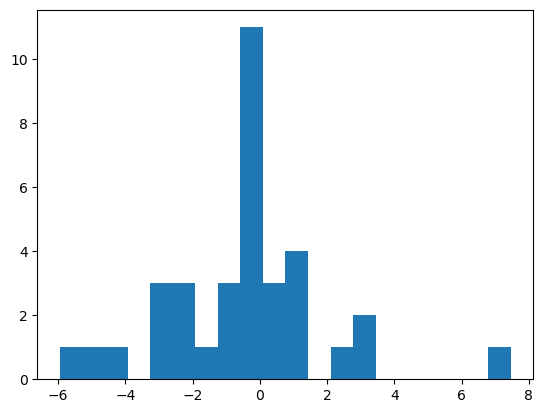

In [18]:
plt.hist(timediff,bins=20)
plt.show()

In [20]:
D10_L02=['LERFUJI_2024-10-15_23-43-13.npz','LERFUJI_2024-10-21_00-35-06.npz','LERFUJI_2024-10-21_08-08-53.npz','LERFUJI_2024-10-21_08-59-35.npz','LERFUJI_2024-10-27_02-02-02.npz',
        'LERFUJI_2024-10-27_05-01-04.npz','LERFUJI_2024-10-27_05-25-07.npz','LERFUJI_2024-10-27_06-17-55.npz',#'LERFUJI_2024-10-27_06-55-20.npz'
         'LERFUJI_2024-10-28_02-55-30.npz',
        'LERFUJI_2024-10-29_23-49-03.npz','LERFUJI_2024-10-30_02-02-03.npz','LERFUJI_2024-11-02_19-05-51.npz',#'LERFUJI_2024-11-03_01-33-25.npz',
         'LERFUJI_2024-11-03_03-58-26.npz','LERFUJI_2024-11-03_17-35-45.npz','LERFUJI_2024-11-03_23-57-50.npz','LERFUJI_2024-11-04_04-14-19.npz','LERFUJI_2024-11-05_11-56-33.npz',
        'LERFUJI_2024-10-23_03-16-57.npz','LERFUJI_2024-10-29_01-41-14.npz','LERFUJI_2024-11-03_03-33-06.npz']
D10_L02_before=np.array([6.66e-7,2.84e-7,1.77e-7,3.44e-7,1.73e-7,1.9e-7,1.76e-7,1.64e-7,#1.91e-7,
                         2.12e-7,2.2e-7,2.27e-7,1.88e-7,#2.2e-7,
                         1.87e-7,1.74e-7,1.64e-7,1.54e-7,1.47e-7,
                        2.06e-7,1.86e-7,1.88e-7])
D10_L02_after=np.array([1.44e-6,4.53e-6,7.87e-7,7.12e-6,1.13e-6,2.58e-6,7.74e-7,1.23e-6,#1.14e-6,
                        1.36e-6,3.43e-7,1.23e-6,7.07e-7,#1.39e-6,
                        1.1e-6,1.81e-6,1.6e-6,9.16e-6,1.64e-6,
                       3.64e-6,2.62e-7,1.06e-6])
D10_L03_before=np.array([])
D10_L03_after=np.array([1.4e-6,4.46e-6,8.99e-7,7.02e-6,1.2e-6,
                       3.09e-6,8.22e-7,1.35e-6,
                       1.35e-6,
                       4.01e-7,1.28e-6,1.02e-6,
                       1.04e-6,1.95e-6,1.91e-6,9.35e-6,1.67e-6,
                       3.93e-6,2.71e-7,1.22e-6])

D04_L07=['LERFUJI_2024-10-15_22-52-26.npz']
D04_L07_before=np.array([3.43e-6])
D04_L07_after=np.array([5.96e-6])

D10_L08=['LERFUJI_2024-10-22_09-20-05.npz','LERFUJI_2024-10-27_13-43-55.npz','LERFUJI_2024-11-11_12-41-57.npz']
D10_L08_before=np.array([2.96e-7,2.75e-7])
D10_L08_after=np.array([8.15e-6,2.48e-6])

D10_L05=['LERFUJI_2024-10-22_09-37-16.npz',
         'LERFUJI_2024-10-27_21-28-33.npz','LERFUJI_2024-10-28_02-30-07.npz','LERFUJI_2024-10-29_19-49-12.npz','LERFUJI_2024-10-30_02-30-10.npz']
D10_L05_before=np.array([2.2e-7,
                         1.57e-7,1.48e-7,1.51e-7,1.66e-7])
D10_L05_after=np.array([1.33e-6,
                        3.06e-7,1.14e-6,9.19e-7,5.22e-7])

#D10_L03=['LERFUJI_2024-10-23_03-16-57.npz','LERFUJI_2024-10-29_01-41-14.npz','LERFUJI_2024-11-03_03-33-06.npz']
#D10_L03_before=np.array([1.91e-7,1.75e-7,1.89e-7])
#D10_L03_after=np.array([3.93e-6,2.71e-7,1.22e-6])

D10_L07=['LERFUJI_2024-11-01_04-31-16.npz','LERFUJI_2024-11-09_23-06-12.npz']
D10_L07_before=np.array([3.2e-7])
D10_L07_after=np.array([6.53e-6])

In [41]:
D10_L02_xydiff=[]
D10_L02_chargediff=[]
for string in D10_L02:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D10_L02_chargediff.append(charge_diff)
    D10_L02_xydiff.append(time_diff)

D04_L07_xydiff=[]
D04_L07_chargediff=[]
for string in D04_L07:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D04_L07_chargediff.append(charge_diff)
    D04_L07_xydiff.append(time_diff)

D10_L08_xydiff=[]
D10_L08_chargediff=[]
for string in D10_L08:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D10_L08_chargediff.append(charge_diff)
    D10_L08_xydiff.append(time_diff)

D10_L05_xydiff=[]
D10_L05_chargediff=[]
for string in D10_L05:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D10_L05_chargediff.append(charge_diff)
    D10_L05_xydiff.append(time_diff)
"""
D10_L03_jmax=[]
D10_L03_chargediff=[]
for string in D10_L03:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D10_L03_chargediff.append(charge_diff)
"""
D10_L07_xydiff=[]
D10_L07_chargediff=[]
for string in D10_L07:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D10_L07_chargediff.append(charge_diff)
    D10_L07_xydiff.append(time_diff)

LERFUJI_2024-10-15_23-43-13.npz
-25260
-22226
-48371
-48755
-4.933398437500003
-4.3408203125
LERFUJI_2024-10-21_00-35-06.npz
-51033
-12937
-46117
-46238
-9.967187500000009
-2.526562499999997
LERFUJI_2024-10-21_08-08-53.npz
-47820
-42569
-40205
-40620
-9.339648437500003
-8.314062500000006
LERFUJI_2024-10-21_08-59-35.npz
-21822
-18316
-13205
-14934
-4.261914062499997
-3.5771484375
LERFUJI_2024-10-27_02-02-02.npz
-25135
-25221
-16509
-16552
-4.908984375000003
-4.92578125
LERFUJI_2024-10-27_05-01-04.npz
-34769
-32558
-25791
-28739
-6.790625000000006
-6.3587890625000085
LERFUJI_2024-10-27_05-25-07.npz
-32632
-23081
-50905
-51024
-6.373242187499997
-4.5078125
LERFUJI_2024-10-27_06-17-55.npz
-48433
-38043
-51032
-51032
-9.459375000000009
-7.4300781250000085
LERFUJI_2024-10-28_02-55-30.npz
-26485
-22414
-16847
-8264
-5.172656250000003
-4.377539062500006
LERFUJI_2024-10-29_23-49-03.npz
-35046
-34336
-18968
-28246
-6.8447265625
-6.7060546875
LERFUJI_2024-10-30_02-02-03.npz
-28737
-23093
-11023
-

In [21]:
D10_L02_xydiff=[]
D10_L02_chargediff=[]
D10_L02_x_timediff=[]
D10_L02_y_timediff=[]
for string in D10_L02:
    i=fuji_file.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file[i])
    mark=0
    datetime_str = fuji_file[i][8:-4]  # "YYYYMMDD_HHMMSS" 部分
    file_datetime = datetime.strptime(datetime_str, "%Y-%m-%d_%H-%M-%S")
    if file_datetime < target_datetime:
        mark=1
    time_diff,charge_diff,x_minmax,y_minmax=make_spectrum(fuji_file[i],D5_file[i],mark=mark)
    D10_L02_chargediff.append(charge_diff)
    D10_L02_xydiff.append(time_diff)
    D10_L02_x_timediff.append(x_minmax)
    D10_L02_y_timediff.append(y_minmax)

LERFUJI_2024-10-15_23-43-13.npz
-25260
-22226
-48371
-48755
-4.933398437500003
-4.3408203125
LERFUJI_2024-10-21_00-35-06.npz
-51033
-12937
-46117
-46238
-9.967187500000009
-2.526562499999997
LERFUJI_2024-10-21_08-08-53.npz
-47820
-42569
-40205
-40620
-9.339648437500003
-8.314062500000006
LERFUJI_2024-10-21_08-59-35.npz
-21822
-18316
-13205
-14934
-4.261914062499997
-3.5771484375
LERFUJI_2024-10-27_02-02-02.npz
-25135
-25221
-16509
-16552
-4.908984375000003
-4.92578125
LERFUJI_2024-10-27_05-01-04.npz
-34769
-32558
-25791
-28739
-6.790625000000006
-6.3587890625000085
LERFUJI_2024-10-27_05-25-07.npz
-32632
-23081
-50905
-51024
-6.373242187499997
-4.5078125
LERFUJI_2024-10-27_06-17-55.npz
-48433
-38043
-51032
-51032
-9.459375000000009
-7.4300781250000085
LERFUJI_2024-10-28_02-55-30.npz
-26485
-22414
-16847
-8264
-5.172656250000003
-4.377539062500006
LERFUJI_2024-10-29_23-49-03.npz
-35046
-34336
-18968
-28246
-6.8447265625
-6.7060546875
LERFUJI_2024-10-30_02-02-03.npz
-28737
-23093
-11023
-

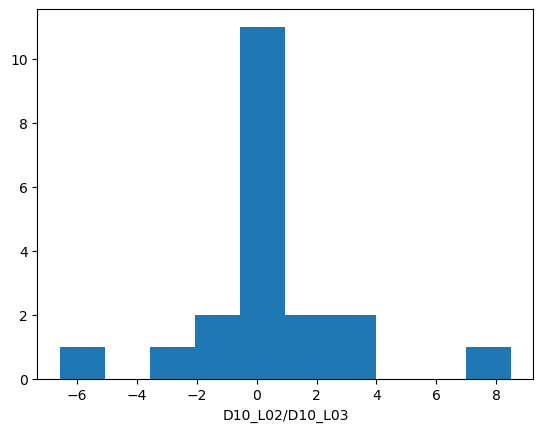

In [18]:
plt.hist(D10_L02_y_timediff)
#plt.xlim(0.75,1.15)
#plt.ylim(0,7)
#plt.grid()
plt.xlabel('D10_L02/D10_L03')

plt.show()

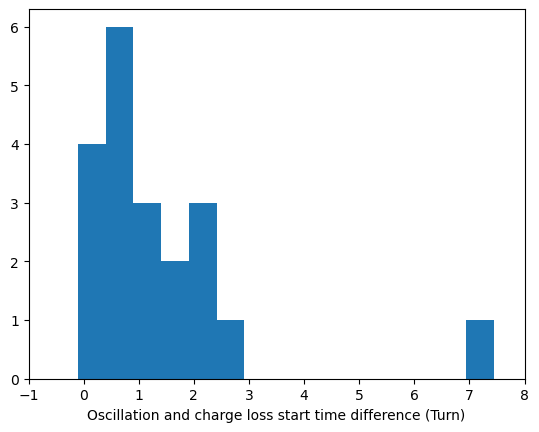

In [7]:
plt.hist(D10_L02_xydiff,bins=15)
plt.xlim(-1,8)
plt.xlabel('Oscillation and charge loss start time difference (Turn)')
plt.show()

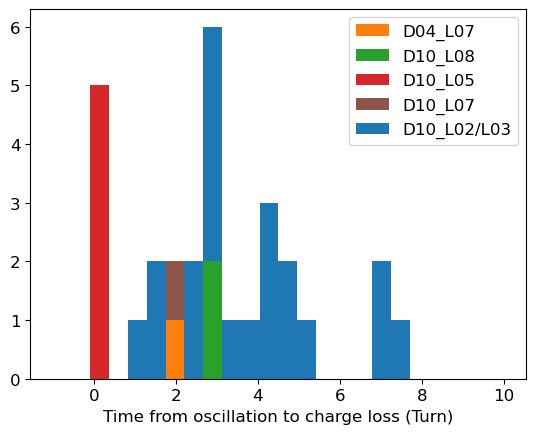

In [61]:
bins = np.linspace(-1,10, 25)

data6=np.abs(np.array(D10_L02_chargediff))
data1=np.abs(np.array(D04_L07_chargediff))
data2=np.abs(np.array(D10_L08_chargediff))
data3=np.abs(np.array(D10_L05_chargediff))
#data4=np.abs(np.array(D10_L03_chargediff))
data5=np.abs(np.array(D10_L07_chargediff))
# 各データのヒストグラムを計算（積み上げ表示用にそれぞれの頻度を得る）
hist1, _ = np.histogram(data1, bins=bins)
hist2, _ = np.histogram(data2, bins=bins)
hist3, _ = np.histogram(data3, bins=bins)
#hist4, _ = np.histogram(data4, bins=bins)
hist5, _ = np.histogram(data5, bins=bins)
hist6, _ = np.histogram(data6, bins=bins)

# 積み上げたヒストグラムを描画
plt.bar(bins[:-1], hist1, width=np.diff(bins), color='tab:orange', label='D04_L07', align='edge')
plt.bar(bins[:-1], hist2, width=np.diff(bins), color='tab:green', label='D10_L08', align='edge', bottom=hist1)
plt.bar(bins[:-1], hist3, width=np.diff(bins), color='tab:red', label='D10_L05', align='edge', bottom=hist1 + hist2)
#plt.bar(bins[:-1], hist4, width=np.diff(bins), color='tab:purple', label='D10_L03', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist5, width=np.diff(bins), color='tab:brown', label='D10_L07', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist6, width=np.diff(bins), color='tab:blue', label='D10_L02/L03', align='edge', bottom=hist1 + hist2 + hist3 + hist5)

# ラベルや凡例を追加
plt.xlabel('Time from oscillation to charge loss (Turn)')
plt.legend()


plt.show()

# only ZCU111

In [42]:
def make_spectrum(filename1):
    npz_kw = np.load('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/'+filename1,allow_pickle=True)
    X_sum=npz_kw['X_sum']
    X_delta=npz_kw['X_delta']
    Y_sum=npz_kw['Y_sum']
    Y_delta=npz_kw['Y_delta']


    if filename1=="LERFUJI_2024-10-16_08-57-48.npz":
        return
    if filename1=="LERFUJI_2024-10-15_19-08-53.npz":
        return
    if filename1=="LERFUJI_2024-10-16_01-58-36.npz":
        Y_sum=np.zeros(len(Y_delta))

    timesteps2=np.arange(len(X_sum))/509
    timesteps2=timesteps2-timesteps2[-1]

    ##################    



    df = pd.DataFrame({'x':timesteps2,'X_sum':X_sum,'X_delta':X_delta,'Y_sum':Y_sum,'Y_delta':Y_delta})
    threshold=2000
    # 条件に従って 'result' を計算
    df['result_x'] = np.where(df['X_sum'] > threshold, df['X_delta'] / df['X_sum'] *(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_x'] = df['result_x'] - df['result_x'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_x'] = np.where(abs(df['result_diff_x']) > 0.7, 0, df['result_diff_x'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_x'])
    moving_avg = df['result_diff_x'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_x'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['x_moving_avg'] = moving_avg.reindex(df.index)
    df['x_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_x'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_x'])
    df['result_interp_x']=df['result_diff_x']#.interpolate(method='spline',order=1)

    df['result_y'] = np.where(df['X_sum'] > threshold, df['Y_delta'] / df['Y_sum'] *(16.58/5), 0)
    # 'result' から 51200 行上の値を引き算
    df['result_diff_y'] = df['result_y'] - df['result_y'].shift(51200)
    # 絶対値が 0.4 を超える場合は 0 に設定
    df['result_diff_y'] = np.where(abs(df['result_diff_y']) > 0.7, 0, df['result_diff_y'])
    # 'X_sum' が 2000 より小さい行の 'result' を NaN にする
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, np.nan, df['result_diff_y'])
    moving_avg = df['result_diff_y'].dropna().rolling(window=500).mean()
    moving_std = df['result_diff_y'].dropna().rolling(window=500).std()
    # 元のDataFrameに移動平均をマージ
    df['y_moving_avg'] = moving_avg.reindex(df.index)
    df['y_moving_std'] = moving_std.reindex(df.index)
    df['result_diff_y'] = np.where(df['X_sum'] <= threshold, 0, df['result_diff_y'])
    df['result_interp_y']=df['result_diff_y']#.interpolate(method='spline',order=1)

    condition = df['X_sum'] <= 2000
    # 連続する2000以下の行数をカウント
    df['group'] = (condition != condition.shift()).cumsum()
    df['count'] = df.groupby('group')['X_sum'].transform('size')
    # 2000以下の連続が300行以上になる部分を削除
    index_to_drop = df[(condition) & (df['count'] >= 300)].index[0] if len(df[(condition) & (df['count'] >= 300)]) > 0 else None
    # 該当部分を削除
    if index_to_drop is not None:
        df = df[:index_to_drop]  # 連続部分の開始行以降を削除



    step_size = 40
    turn=len(df)//5120-15
    if turn<10:
        return np.nan
    tbtdata_111_x=df['result_interp_x'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_ma=df['x_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_x_std=df['x_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y=df['result_interp_y'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_ma=df['y_moving_avg'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    tbtdata_111_y_std=df['y_moving_std'].iloc[len(df)-5120*turn:len(df)-0*5120].values
    
    #tbtdata_111=tbtdata_111.reshape(turn,5120)
    turn111=turn

    a=tbtdata_111_x_ma[-15*5120:]
    b=tbtdata_111_x_std[-15*5120:]*0.5
    index_111 = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            0
        )
    index_111=index_111-15*5120
    print(index_111)
    a=tbtdata_111_y_ma[-15*5120:]
    b=tbtdata_111_y_std[-15*5120:]*0.5
    index_111_y = next(
            (i for i, (a_val, b_val) in enumerate(zip(a, b))
             if not np.isnan(a_val) and not np.isnan(b_val) and abs(a_val) > b_val),
            0
        )
    index_111_y=index_111_y-15*5120
    print(index_111_y)

    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True,figsize=(16,4))
    timeaxis=np.arange(len(tbtdata_111_x))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax1.set_title(f'{filename1[8:-4]}')
    ax1.scatter(timeaxis,tbtdata_111_x,c='red',s=1)
    ax1.plot(timeaxis,tbtdata_111_x_ma,'o-',c='green',markersize=0.02)
    #ax1.plot(timeaxis,tbtdata_111_x_std,'o-',c='green',markersize=1)
    time_111=timeaxis[index_111]
    ax1.vlines(time_111,-0.6,0.6)
    ax1.grid()
    ax1.set_ylim(-0.6,0.6)
    ax1.set_ylabel('Fuji X pos (mm)')
    timeaxis=np.arange(len(tbtdata_111_y))/5120
    timeaxis=timeaxis-timeaxis[-1]
    ax2.scatter(timeaxis,tbtdata_111_y,c='red',s=1)
    ax2.plot(timeaxis,tbtdata_111_y_ma,'o-',c='green',markersize=0.02)
    #ax2.plot(timeaxis,tbtdata_111_y_std,'o-',c='green',markersize=1)
    time_111_y=timeaxis[index_111_y]
    ax2.vlines(time_111_y,-0.6,0.6)
    ax2.grid()
    ax2.set_ylim(-0.6,0.6)
    ax2.set_xticks([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0])
    ax2.set_ylabel('Fuji Y pos (mm)')
    plt.xlim(-10,0)
    plt.xlabel('Turn')
    plt.savefig(f'combined_analysis/{filename1[8:-4]}_111.png',dpi=100)
    plt.close()

    return time_111,time_111_y,np.nanmax(tbtdata_111_x_ma)-np.nanmin(tbtdata_111_x_ma),np.nanmax(tbtdata_111_y_ma)-np.nanmin(tbtdata_111_y_ma)

In [11]:
os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/')

['LERFUJI_2024-10-27_02-02-02.npz',
 'LERFUJI_2024-10-20_13-51-29.npz',
 'LERFUJI_2024-11-02_16-48-53.npz',
 'LERFUJI_2024-10-21_08-08-53.npz',
 'LERFUJI_2024-10-29_23-49-03.npz',
 'LERFUJI_2024-10-28_02-30-07.npz',
 'LERFUJI_2024-11-01_04-31-16.npz',
 'LERFUJI_2024-10-27_06-17-55.npz',
 'LERFUJI_2024-10-27_23-44-12.npz',
 'LERFUJI_2024-11-04_04-14-19.npz',
 'LERFUJI_2024-10-30_02-30-10.npz',
 'LERFUJI_2024-10-22_09-20-05.npz',
 'LERFUJI_2024-10-15_23-43-13.npz',
 'LERFUJI_2024-10-15_20-22-59.npz',
 'LERFUJI_2024-10-21_08-59-35.npz',
 'LERFUJI_2024-10-23_03-16-57.npz',
 'LERFUJI_2024-11-03_01-33-25.npz',
 'LERFUJI_2024-10-16_04-52-14.npz',
 'LERFUJI_2024-10-15_20-56-49.npz',
 'LERFUJI_2024-10-27_05-25-07.npz',
 'LERFUJI_2024-11-02_19-05-51.npz',
 'LERFUJI_2024-10-30_02-02-03.npz',
 'LERFUJI_2024-10-28_02-55-30.npz',
 'LERFUJI_2024-11-03_23-57-50.npz',
 'LERFUJI_2024-10-21_00-35-06.npz',
 'LERFUJI_2024-11-03_03-58-26.npz',
 'LERFUJI_2024-10-18_02-29-34.npz',
 'LERFUJI_2024-10-15_22-52-2

In [51]:
D10_L02=['LERFUJI_2024-10-15_23-43-13.npz','LERFUJI_2024-10-21_00-35-06.npz','LERFUJI_2024-10-21_08-08-53.npz','LERFUJI_2024-10-21_08-59-35.npz','LERFUJI_2024-10-27_02-02-02.npz',
        'LERFUJI_2024-10-27_05-01-04.npz','LERFUJI_2024-10-27_05-25-07.npz','LERFUJI_2024-10-27_06-17-55.npz','LERFUJI_2024-10-27_06-55-20.npz','LERFUJI_2024-10-28_02-55-30.npz',
        'LERFUJI_2024-10-29_23-49-03.npz','LERFUJI_2024-10-30_02-02-03.npz','LERFUJI_2024-11-02_19-05-51.npz',#'LERFUJI_2024-11-03_01-33-25.npz',
         'LERFUJI_2024-11-03_03-58-26.npz','LERFUJI_2024-11-03_17-35-45.npz','LERFUJI_2024-11-03_23-57-50.npz','LERFUJI_2024-11-04_04-14-19.npz','LERFUJI_2024-11-05_11-56-33.npz',
        'LERFUJI_2024-10-15_20-56-49.npz','LERFUJI_2024-10-19_18-05-55.npz','LERFUJI_2024-10-19_21-33-36.npz','LERFUJI_2024-10-20_13-51-29.npz','LERFUJI_2024-10-20_21-14-56.npz',
        'LERFUJI_2024-10-23_03-16-57.npz','LERFUJI_2024-10-29_01-41-14.npz','LERFUJI_2024-11-03_03-33-06.npz']
D10_L02_before=np.array([6.66e-7,2.84e-7,1.77e-7,3.44e-7,1.73e-7,1.9e-7,1.76e-7,1.64e-7,1.91e-7,2.12e-7,2.2e-7,2.27e-7,1.88e-7,#2.2e-7,
                         1.87e-7,1.74e-7,1.64e-7,1.54e-7,1.47e-7,5.95e-7,4.3e-7,4.25e-7,3.81e-7,3.05e-7,
                        1.91e-7,1.75e-7,1.89e-7])
D10_L02_after=np.array([1.44e-6,4.53e-6,7.87e-7,7.12e-6,1.13e-6,2.58e-6,7.74e-7,1.23e-6,1.14e-6,1.36e-6,3.43e-7,1.23e-6,7.07e-7,#1.39e-6,
                        1.1e-6,1.81e-6,1.6e-6,9.16e-6,1.64e-6,1.01e-6,1.35e-6,1.49e-6,3.16e-6,7.75e-7,
                       3.93e-6,2.71e-7,1.22e-6])

D04_L07=['LERFUJI_2024-10-15_22-52-26.npz','LERFUJI_2024-10-15_20-22-59.npz']
D04_L07_before=np.array([3.43e-6,2.68e-6])
D04_L07_after=np.array([5.96e-6,1.29e-5])

D10_L08=['LERFUJI_2024-10-22_09-20-05.npz','LERFUJI_2024-10-27_13-43-55.npz']
D10_L08_before=np.array([2.96e-7,2.75e-7])
D10_L08_after=np.array([8.15e-6,2.48e-6])

D10_L05=['LERFUJI_2024-10-22_09-37-16.npz','LERFUJI_2024-10-27_21-28-33.npz','LERFUJI_2024-10-28_02-30-07.npz','LERFUJI_2024-10-29_19-49-12.npz','LERFUJI_2024-10-30_02-30-10.npz']
D10_L05_before=np.array([2.2e-7,1.57e-7,1.48e-7,1.51e-7,1.66e-7])
D10_L05_after=np.array([1.33e-6,3.06e-7,1.14e-6,9.19e-7,5.22e-7])

#D10_L03=['LERFUJI_2024-10-23_03-16-57.npz','LERFUJI_2024-10-29_01-41-14.npz','LERFUJI_2024-11-03_03-33-06.npz']
#D10_L03_before=np.array([1.91e-7,1.75e-7,1.89e-7])
#D10_L03_after=np.array([3.93e-6,2.71e-7,1.22e-6])

D10_L07=['LERFUJI_2024-11-01_04-31-16.npz'#,'LERFUJI_2024-10-15_20-04-25.npz'
        ]
D10_L07_before=np.array([3.2e-7#,6.53e-7
                        ])
D10_L07_after=np.array([6.53e-6#,2.27e-6
                       ])

In [38]:
len(D10_L08)

1

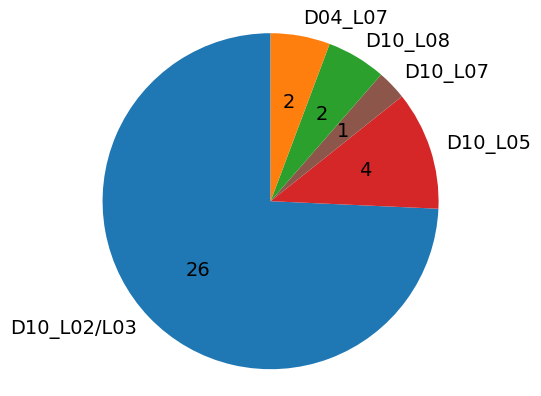

In [52]:
labels = ['D10_L02/L03', 'D10_L05', 'D10_L07', 'D10_L08','D04_L07']
sizes = [26,4,1,2,2]  # 各カテゴリの割合
colors = ['tab:blue','tab:red','tab:brown','tab:green','tab:orange']  # 色の指定
explode = (0, 0, 0, 0,0)  # Aの部分を少し引き出す

def size_label(pct, sizes):
    absolute = int(round(pct / 100. * sum(sizes), 1))  # 四捨五入して小数第1位まで表示
    return f'{absolute}'
# 円グラフの描画
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct=lambda pct: size_label(pct, sizes), startangle=90,textprops={'fontsize': 14})
plt.axis('equal')  # 円を丸くするための設定
plt.show()



In [53]:
D10_L02_time_y=[]
D10_L02_time_x=[]
D10_L02_shinpuku_y=[]
D10_L02_shinpuku_x=[]

fuji_file_=os.listdir('/mnt/SBOR/2024c_RFSoC/ZCU111/SBL/')
for string in D10_L02:
    index=fuji_file_.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file_[index])
    a,b,c,d=make_spectrum(fuji_file_[index])
    D10_L02_time_x.append(a)
    D10_L02_time_y.append(b)
    D10_L02_shinpuku_x.append(c)
    D10_L02_shinpuku_y.append(d)

D04_L07_time_y=[]
D04_L07_time_x=[]
D04_L07_shinpuku_y=[]
D04_L07_shinpuku_x=[]
for string in D04_L07:
    index=fuji_file_.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file_[index])
    a,b,c,d=make_spectrum(fuji_file_[index])
    D04_L07_time_x.append(a)
    D04_L07_time_y.append(b)
    D04_L07_shinpuku_x.append(c)
    D04_L07_shinpuku_y.append(d)


D10_L08_time_y=[]
D10_L08_time_x=[]
D10_L08_shinpuku_y=[]
D10_L08_shinpuku_x=[]
for string in D10_L08:
    index=fuji_file_.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file_[index])
    a,b,c,d=make_spectrum(fuji_file_[index])
    D10_L08_time_x.append(a)
    D10_L08_time_y.append(b)
    D10_L08_shinpuku_x.append(c)
    D10_L08_shinpuku_y.append(d)

D10_L05_time_y=[]
D10_L05_time_x=[]
D10_L05_shinpuku_y=[]
D10_L05_shinpuku_x=[]
for string in D10_L05:
    index=fuji_file_.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file_[index])
    a,b,c,d=make_spectrum(fuji_file_[index])
    D10_L05_time_x.append(a)
    D10_L05_time_y.append(b)
    D10_L05_shinpuku_x.append(c)
    D10_L05_shinpuku_y.append(d)

"""
D10_L03_time_y=[]
D10_L03_time_x=[]
D10_L03_shinpuku_y=[]
D10_L03_shinpuku_x=[]
for string in D10_L03:
    index=fuji_file_.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file_[index])
    a,b,c,d=make_spectrum(fuji_file_[index])
    D10_L03_time_x.append(a)
    D10_L03_time_y.append(b)
    D10_L03_shinpuku_x.append(c)
    D10_L03_shinpuku_y.append(d)
"""
D10_L07_time_y=[]
D10_L07_time_x=[]
D10_L07_shinpuku_y=[]
D10_L07_shinpuku_x=[]
for string in D10_L07:
    index=fuji_file_.index(string)
    target_datetime = datetime(2024, 10, 27, 7, 0, 0)
    print(fuji_file_[index])
    a,b,c,d=make_spectrum(fuji_file_[index])
    D10_L07_time_x.append(a)
    D10_L07_time_y.append(b)
    D10_L07_shinpuku_x.append(c)
    D10_L07_shinpuku_y.append(d)

LERFUJI_2024-10-15_23-43-13.npz
-25260
-22226
LERFUJI_2024-10-21_00-35-06.npz
-75812
-12937
LERFUJI_2024-10-21_08-08-53.npz
-47820
-42569
LERFUJI_2024-10-21_08-59-35.npz
-21822
-18316
LERFUJI_2024-10-27_02-02-02.npz
-25135
-25221
LERFUJI_2024-10-27_05-01-04.npz
-34769
-32558
LERFUJI_2024-10-27_05-25-07.npz
-32632
-23081
LERFUJI_2024-10-27_06-17-55.npz
-69868
-38043
LERFUJI_2024-10-27_06-55-20.npz
-35260
-22778
LERFUJI_2024-10-28_02-55-30.npz
-26485
-22414
LERFUJI_2024-10-29_23-49-03.npz
-35046
-34336
LERFUJI_2024-10-30_02-02-03.npz
-28737
-23093
LERFUJI_2024-11-02_19-05-51.npz
-22780
-20027
LERFUJI_2024-11-03_03-58-26.npz
-35427
-24973
LERFUJI_2024-11-03_17-35-45.npz
-76636
-31754
LERFUJI_2024-11-03_23-57-50.npz
-29231
-29491
LERFUJI_2024-11-04_04-14-19.npz
-32992
-27857
LERFUJI_2024-11-05_11-56-33.npz
-37978
-33997
LERFUJI_2024-10-15_20-56-49.npz
-18081
-3968
LERFUJI_2024-10-19_18-05-55.npz
-21487
-18933
LERFUJI_2024-10-19_21-33-36.npz
-35483
-29189
LERFUJI_2024-10-20_13-51-29.npz
-73

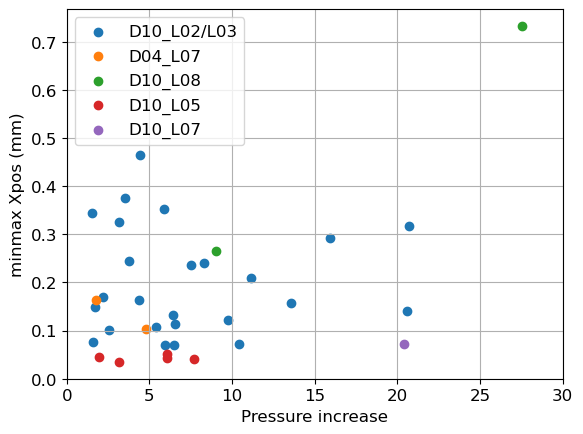

In [54]:
plt.scatter((D10_L02_after/D10_L02_before),np.array(D10_L02_shinpuku_x),label='D10_L02/L03')
plt.scatter((D04_L07_after/D04_L07_before),np.array(D04_L07_shinpuku_x),label='D04_L07')
plt.scatter((D10_L08_after/D10_L08_before),np.array(D10_L08_shinpuku_x),label='D10_L08')
plt.scatter((D10_L05_after/D10_L05_before),np.array(D10_L05_shinpuku_x),label='D10_L05')
#plt.scatter((D10_L03_after/D10_L03_before),np.array(D10_L03_shinpuku_x),label='D10_L03')
plt.scatter((D10_L07_after/D10_L07_before),np.array(D10_L07_shinpuku_x),label='D10_L07')
plt.xlim(0,30)
#plt.ylim(0.05,0.25)
plt.legend()
plt.grid()
plt.ylabel('minmax Xpos (mm)')
plt.xlabel('Pressure increase')
plt.show()

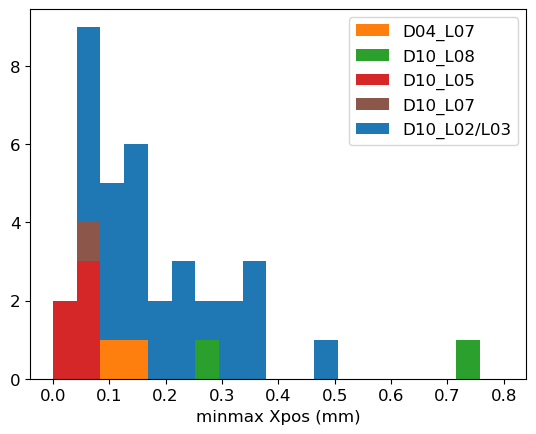

In [55]:
bins = np.linspace(0,0.8, 20)

data6=np.array(D10_L02_shinpuku_x)
data1=np.array(D04_L07_shinpuku_x)
data2=np.array(D10_L08_shinpuku_x)
data3=np.array(D10_L05_shinpuku_x)
#data4=np.array(D10_L03_shinpuku_x)
data5=np.array(D10_L07_shinpuku_x)
# 各データのヒストグラムを計算（積み上げ表示用にそれぞれの頻度を得る）
hist1, _ = np.histogram(data1, bins=bins)
hist2, _ = np.histogram(data2, bins=bins)
hist3, _ = np.histogram(data3, bins=bins)
#hist4, _ = np.histogram(data4, bins=bins)
hist5, _ = np.histogram(data5, bins=bins)
hist6, _ = np.histogram(data6, bins=bins)

# 積み上げたヒストグラムを描画
plt.bar(bins[:-1], hist1, width=np.diff(bins), color='tab:orange', label='D04_L07', align='edge')
plt.bar(bins[:-1], hist2, width=np.diff(bins), color='tab:green', label='D10_L08', align='edge', bottom=hist1)
plt.bar(bins[:-1], hist3, width=np.diff(bins), color='tab:red', label='D10_L05', align='edge', bottom=hist1 + hist2)
#plt.bar(bins[:-1], hist4, width=np.diff(bins), color='tab:purple', label='D10_L03', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist5, width=np.diff(bins), color='tab:brown', label='D10_L07', align='edge', bottom=hist1 + hist2 + hist3 )
plt.bar(bins[:-1], hist6, width=np.diff(bins), color='tab:blue', label='D10_L02/L03', align='edge', bottom=hist1 + hist2 + hist3 + hist5)

# ラベルや凡例を追加
plt.xlabel('minmax Xpos (mm)')
plt.legend()


plt.show()

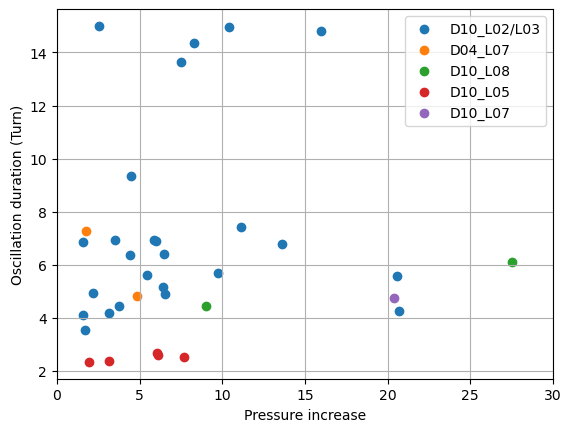

In [18]:
plt.scatter((D10_L02_after/D10_L02_before),np.abs(np.array(D10_L02_time_x)),label='D10_L02/L03')
plt.scatter((D04_L07_after/D04_L07_before),np.abs(np.array(D04_L07_time_x)),label='D04_L07')
plt.scatter((D10_L08_after/D10_L08_before),np.abs(np.array(D10_L08_time_x)),label='D10_L08')
plt.scatter((D10_L05_after/D10_L05_before),np.abs(np.array(D10_L05_time_x)),label='D10_L05')
#plt.scatter((D10_L03_after/D10_L03_before),np.abs(np.array(D10_L03_time_x)),label='D10_L03')
plt.scatter((D10_L07_after/D10_L07_before),np.abs(np.array(D10_L07_time_x)),label='D10_L07')
plt.xlim(0,30)
#plt.ylim(0.05,0.25)
plt.legend()
plt.grid()
plt.xlabel('Pressure increase')
plt.ylabel('Oscillation duration (Turn)')
plt.show()

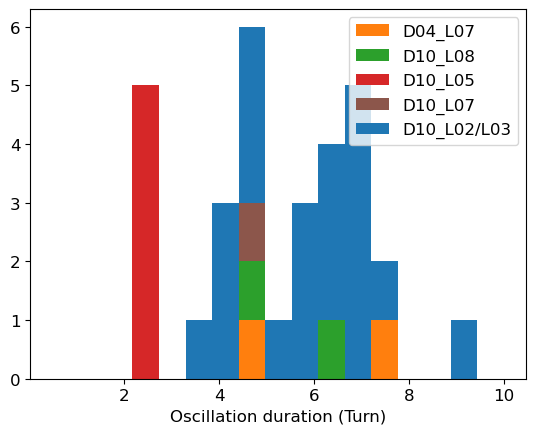

In [56]:
bins = np.linspace(0.5,10, 18)

data6=np.abs(np.array(D10_L02_time_x))
data1=np.abs(np.array(D04_L07_time_x))
data2=np.abs(np.array(D10_L08_time_x))
data3=np.abs(np.array(D10_L05_time_x))
#data4=np.abs(np.array(D10_L03_time_x))
data5=np.abs(np.array(D10_L07_time_x))
# 各データのヒストグラムを計算（積み上げ表示用にそれぞれの頻度を得る）
hist1, _ = np.histogram(data1, bins=bins)
hist2, _ = np.histogram(data2, bins=bins)
hist3, _ = np.histogram(data3, bins=bins)
#hist4, _ = np.histogram(data4, bins=bins)
hist5, _ = np.histogram(data5, bins=bins)
hist6, _ = np.histogram(data6, bins=bins)

# 積み上げたヒストグラムを描画
plt.rcParams["font.size"] = 12 
plt.bar(bins[:-1], hist1, width=np.diff(bins), color='tab:orange', label='D04_L07', align='edge')
plt.bar(bins[:-1], hist2, width=np.diff(bins), color='tab:green', label='D10_L08', align='edge', bottom=hist1)
plt.bar(bins[:-1], hist3, width=np.diff(bins), color='tab:red', label='D10_L05', align='edge', bottom=hist1 + hist2)
#plt.bar(bins[:-1], hist4, width=np.diff(bins), color='tab:purple', label='D10_L03', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist5, width=np.diff(bins), color='tab:brown', label='D10_L07', align='edge', bottom=hist1 + hist2 + hist3 )
plt.bar(bins[:-1], hist6, width=np.diff(bins), color='tab:blue', label='D10_L02/L03', align='edge', bottom=hist1 + hist2 + hist3  + hist5)

# ラベルや凡例を追加
plt.xlabel('Oscillation duration (Turn)')
plt.legend()


plt.show()

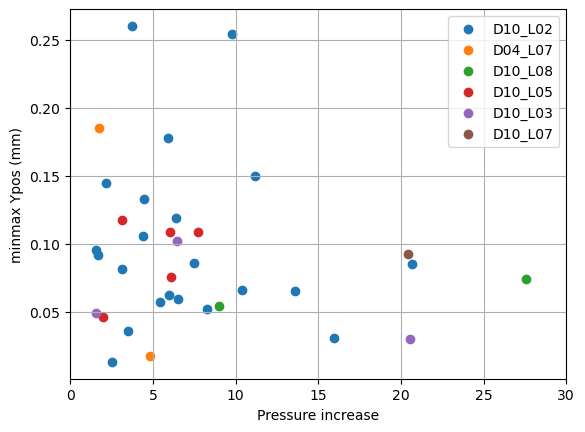

In [51]:
plt.scatter((D10_L02_after/D10_L02_before),D10_L02_shinpuku_y,label='D10_L02')
plt.scatter((D04_L07_after/D04_L07_before),D04_L07_shinpuku_y,label='D04_L07')
plt.scatter((D10_L08_after/D10_L08_before),D10_L08_shinpuku_y,label='D10_L08')
plt.scatter((D10_L05_after/D10_L05_before),D10_L05_shinpuku_y,label='D10_L05')
plt.scatter((D10_L03_after/D10_L03_before),D10_L03_shinpuku_y,label='D10_L03')
plt.scatter((D10_L07_after/D10_L07_before),D10_L07_shinpuku_y,label='D10_L07')
plt.xlim(0,30)
#plt.ylim(0.05,0.25)
plt.legend()
plt.grid()
plt.xlabel('Pressure increase')
plt.ylabel('minmax Ypos (mm)')
plt.show()

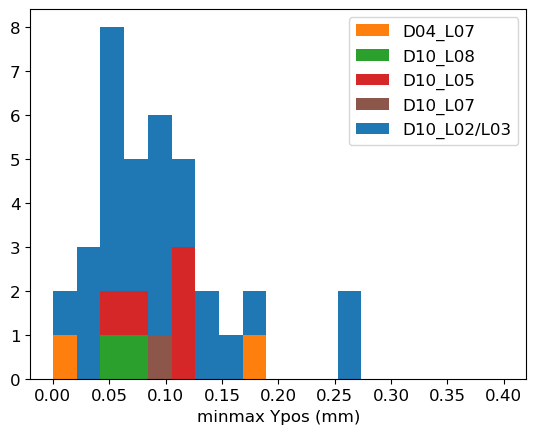

In [42]:
bins = np.linspace(0,0.4, 20)

data6=np.abs(np.array(D10_L02_shinpuku_y))
data1=np.abs(np.array(D04_L07_shinpuku_y))
data2=np.abs(np.array(D10_L08_shinpuku_y))
data3=np.abs(np.array(D10_L05_shinpuku_y))
#data4=np.abs(np.array(D10_L03_shinpuku_y))
data5=np.abs(np.array(D10_L07_shinpuku_y))
# 各データのヒストグラムを計算（積み上げ表示用にそれぞれの頻度を得る）
hist1, _ = np.histogram(data1, bins=bins)
hist2, _ = np.histogram(data2, bins=bins)
hist3, _ = np.histogram(data3, bins=bins)
#hist4, _ = np.histogram(data4, bins=bins)
hist5, _ = np.histogram(data5, bins=bins)
hist6, _ = np.histogram(data6, bins=bins)

# 積み上げたヒストグラムを描画
plt.rcParams["font.size"] = 12 
plt.bar(bins[:-1], hist1, width=np.diff(bins), color='tab:orange', label='D04_L07', align='edge')
plt.bar(bins[:-1], hist2, width=np.diff(bins), color='tab:green', label='D10_L08', align='edge', bottom=hist1)
plt.bar(bins[:-1], hist3, width=np.diff(bins), color='tab:red', label='D10_L05', align='edge', bottom=hist1 + hist2)
#plt.bar(bins[:-1], hist4, width=np.diff(bins), color='tab:purple', label='D10_L03', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist5, width=np.diff(bins), color='tab:brown', label='D10_L07', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist6, width=np.diff(bins), color='tab:blue', label='D10_L02/L03', align='edge', bottom=hist1 + hist2 + hist3 + hist5)

# ラベルや凡例を追加
plt.xlabel('minmax Ypos (mm)')
plt.legend()


plt.show()

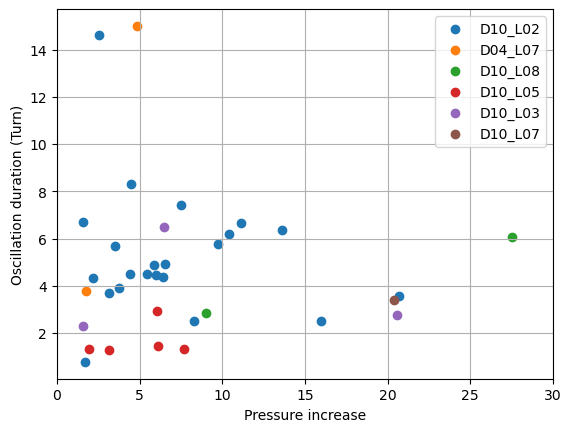

In [56]:
plt.scatter((D10_L02_after/D10_L02_before),np.abs(np.array(D10_L02_time_y)),label='D10_L02')
plt.scatter((D04_L07_after/D04_L07_before),np.abs(np.array(D04_L07_time_y)),label='D04_L07')
plt.scatter((D10_L08_after/D10_L08_before),np.abs(np.array(D10_L08_time_y)),label='D10_L08')
plt.scatter((D10_L05_after/D10_L05_before),np.abs(np.array(D10_L05_time_y)),label='D10_L05')
plt.scatter((D10_L03_after/D10_L03_before),np.abs(np.array(D10_L03_time_y)),label='D10_L03')
plt.scatter((D10_L07_after/D10_L07_before),np.abs(np.array(D10_L07_time_y)),label='D10_L07')
plt.xlim(0,30)
#plt.ylim(0.05,0.25)
plt.legend()
plt.grid()
plt.xlabel('Pressure increase')
plt.ylabel('Oscillation duration (Turn)')
plt.show()

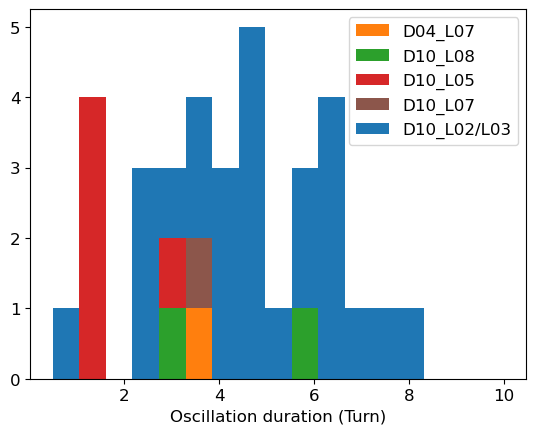

In [45]:
bins = np.linspace(0.5,10, 18)

data6=np.abs(np.array(D10_L02_time_y))
data1=np.abs(np.array(D04_L07_time_y))
data2=np.abs(np.array(D10_L08_time_y))
data3=np.abs(np.array(D10_L05_time_y))
#data4=np.abs(np.array(D10_L03_time_y))
data5=np.abs(np.array(D10_L07_time_y))
# 各データのヒストグラムを計算（積み上げ表示用にそれぞれの頻度を得る）
hist1, _ = np.histogram(data1, bins=bins)
hist2, _ = np.histogram(data2, bins=bins)
hist3, _ = np.histogram(data3, bins=bins)
#hist4, _ = np.histogram(data4, bins=bins)
hist5, _ = np.histogram(data5, bins=bins)
hist6, _ = np.histogram(data6, bins=bins)

# 積み上げたヒストグラムを描画
plt.rcParams["font.size"] = 12 
plt.bar(bins[:-1], hist1, width=np.diff(bins), color='tab:orange', label='D04_L07', align='edge')
plt.bar(bins[:-1], hist2, width=np.diff(bins), color='tab:green', label='D10_L08', align='edge', bottom=hist1)
plt.bar(bins[:-1], hist3, width=np.diff(bins), color='tab:red', label='D10_L05', align='edge', bottom=hist1 + hist2)
#plt.bar(bins[:-1], hist4, width=np.diff(bins), color='tab:purple', label='D10_L03', align='edge', bottom=hist1 + hist2 + hist3)
plt.bar(bins[:-1], hist5, width=np.diff(bins), color='tab:brown', label='D10_L07', align='edge', bottom=hist1 + hist2 + hist3 )
plt.bar(bins[:-1], hist6, width=np.diff(bins), color='tab:blue', label='D10_L02/L03', align='edge', bottom=hist1 + hist2 + hist3 + hist5)

# ラベルや凡例を追加

plt.legend()
plt.xlabel('Oscillation duration (Turn)')

plt.show()